In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import xgboost
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import shap
shap.initjs()

In [4]:
import random
random.seed(999)
np.random.seed(999)

In [9]:
## TODO 
# run the tpot automated ml for optimized model
# normalise/scale the high,low,open and close prices & computed features
# using time-lagged features
# ichimoku analysis & generate features based on signal crossovers and trend reversals

## Preparing Data 


In [5]:
def zscore_func_improved(x,window_size=20):
    rolling_mean=x.rolling(window=window_size).mean().bfill()
    rolling_std = x.rolling(window=window_size).std().bfill()
    return (x-rolling_mean)/rolling_std

In [278]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')
fcpo_daily_tind=pd.read_hdf('processed_dta.h5','fcpo_daily_tind')
fcpo_daily_cdlind=pd.read_hdf('processed_dta.h5','fcpo_daily_cdlind')
fcpo_daily_cind = pd.read_hdf('processed_dta.h5','fcpo_daily_cind')

fcpo_daily_feats=fcpo_daily_tind.merge(fcpo_daily_cdlind,left_index=True,right_index=True)
#fcpo_data_daily[['Open','High','Low','Close']]=fcpo_data_daily[['Open','High','Low','Close']].apply(lambda x: zscore_func_improved(x))
## using the subset of data for training to exclude 2008 oil crisis
fcpo_daily_feats=fcpo_daily_feats['2008-01-01':'2017-01-01']

In [7]:
## read the non back-adjusted data
fcpo_data_new=pd.read_hdf('processed_dta.h5','fcpo_data_new')
fcpo_new_tind=pd.read_hdf('processed_dta.h5','fcpo_new_tind')
fcpo_new_cdlind=pd.read_hdf('processed_dta.h5','fcpo_new_cdlind')

fcpo_new_feats=fcpo_new_tind.merge(fcpo_new_cdlind,left_index=True,right_index=True)
#fcpo_new_feats=fcpo_new_feats['2011-01-01':'2018-10-01']

## Machine Learning models

In [9]:
def build_modeling_data(fcpo_data_daily,fcpo_feats,target_label='lprofit_ind',split_date='2017-01-01'):
    fcpo_train=fcpo_feats[:split_date]
    fcpo_test = fcpo_feats[split_date:]

    fcpo_train=fcpo_train.merge(fcpo_data_daily[['Open','prev_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_traindata=fcpo_train.iloc[:,0:-1]
    fcpo_trainlabels=fcpo_train.iloc[:,-1:]
    
    fcpo_test=fcpo_test.merge(fcpo_data_daily[['Open','prev_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_testdata=fcpo_test.iloc[:,0:-1]
    fcpo_testlabels=fcpo_test.iloc[:,-1]
    return fcpo_traindata,fcpo_trainlabels,fcpo_testdata,fcpo_testlabels

def buil_cross_validated_model(ml_model,traindata,trainlabels,tsplit,scoring_metric='roc_auc'):
    ml_cval_scores=cross_val_score(ml_model,traindata,np.ravel(trainlabels),
                                       scoring=scoring_metric,cv=tsplit)
    ml_model.fit(traindata,np.ravel(trainlabels))
    return ml_model,ml_cval_scores

### Time-series cross validation

In [10]:
fcpo_tsplit=TimeSeriesSplit(n_splits=3)

## Long call trading model 

In [279]:
fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,fcpo_lprofit_testdata,fcpo_lprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                fcpo_daily_feats,'lprofit_ind_2pct','2016-01-01')

In [23]:
### Compute cross-validation scores using time-series splits for a defined configuration ###
rf_lprofit= RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_split=2,
                                  min_samples_leaf=2,criterion='gini',random_state=333)
rf_lprofit,rf_lprofit_cval_scores=buil_cross_validated_model(rf_lprofit,fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,
                                                                fcpo_tsplit)

In [280]:
rf_lprofit_test_proba=rf_lprofit.predict_proba(fcpo_lprofit_testdata)
rf_lprofit_test_predlabels=rf_lprofit.predict(fcpo_lprofit_testdata)

#### GBM

In [25]:
gbm_lprofit=GradientBoostingClassifier(n_estimators=500,max_depth=10,min_samples_leaf=2,
                                       min_samples_split=2,learning_rate=0.01,random_state=333)
gbm_lprofit,gbm_lprofit_cval_scores=buil_cross_validated_model(gbm_lprofit,fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,
                                                                fcpo_tsplit)

In [281]:
gbm_lprofit_test_proba=gbm_lprofit.predict_proba(fcpo_lprofit_testdata)
gbm_lprofit_test_predlabels=gbm_lprofit.predict(fcpo_lprofit_testdata)

### XGBoost

In [27]:
xgb_lprofit=xgboost.XGBClassifier(objective='binary:logistic',max_depth=10,n_estimators=500,learning_rate=0.01,gamma=0.01,
                                    subsample=0.8,colsample_bytree=0.8,n_jobs=-1,random_state=333)

xgb_lprofit,xgb_lprofit_cval_scores=buil_cross_validated_model(xgb_lprofit,fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,
                                                                fcpo_tsplit)

#xgb_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

In [282]:
xgb_lprofit_test_proba=xgb_lprofit.predict_proba(fcpo_lprofit_testdata)
xgb_lprofit_test_predlabels=xgb_lprofit.predict(fcpo_lprofit_testdata)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



### Search for Best fitting parameters

In [30]:
## Use the RandomSearch funciton to find the best hyper parameters of Random forrests
rf_param_dist = {"max_depth": [6,12,18],
                  "min_samples_split": [2,4,6],
                  "min_samples_leaf": [1,2,4],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

xgb_param_dist={"max_depth": [10,20,50],
                "learning_rate": [0.01,0.02,0.05,0.1],
                "n_estimators": [100,200,300,500],
                "gamma": [0,0.01,0.05],
                "subsample": [0.8,1],
                "colsample_bytree": [0.8,1]  
}

In [30]:
%%time
rf_lprofit_rsearch=RandomizedSearchCV(RandomForestClassifier(n_estimators=500,max_depth=12,n_jobs=-1),
                                      rf_param_dist,cv=fcpo_tsplit,scoring='roc_auc',n_iter=50,n_jobs=-1)

#rf_lprofit_rsearch=rf_lprofit_rsearch.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

In [30]:
%%time
xgb_lprofit_rsearch=RandomizedSearchCV(xgboost.XGBClassifier(),
                                      xgb_param_dist,cv=fcpo_tsplit,scoring='roc_auc',n_iter=500,n_jobs=-1)


#xgb_lprofit_rsearch=xgb_lprofit_rsearch.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

## Short call trading model 

In [283]:
fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,fcpo_sprofit_testdata,fcpo_sprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                fcpo_daily_feats,'sprofit_ind_2pct','2016-01-01')

#### Random Forrest

In [34]:
rf_sprofit= RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_split=2,
                                  min_samples_leaf=2,criterion='entropy',random_state=333)
rf_sprofit,rf_sprofit_cval_scores=buil_cross_validated_model(rf_sprofit,fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,
                                                                fcpo_tsplit)

In [284]:
rf_sprofit_test_proba=rf_sprofit.predict_proba(fcpo_sprofit_testdata)
rf_sprofit_test_predlabels=rf_sprofit.predict(fcpo_sprofit_testdata)

#### GBM 

In [36]:
gbm_sprofit=GradientBoostingClassifier(n_estimators=500,max_depth=10,min_samples_leaf=2,
                                       min_samples_split=2,learning_rate=0.01,random_state=333)
gbm_sprofit,gbm_sprofit_cval_scores=buil_cross_validated_model(gbm_sprofit,fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,
                                                                fcpo_tsplit)

In [285]:
gbm_sprofit_test_proba=gbm_sprofit.predict_proba(fcpo_sprofit_testdata)
gbm_sprofit_test_predlabels=gbm_sprofit.predict(fcpo_sprofit_testdata)

### XGBoost

In [38]:
xgb_sprofit=xgboost.XGBClassifier(objective='binary:logistic',max_depth=10,n_estimators=500,learning_rate=0.01,gamma=0.01,
                                    subsample=0.8,colsample_bytree=0.8,n_jobs=-1,random_state=333)

xgb_sprofit,xgb_sprofit_cval_scores=buil_cross_validated_model(xgb_sprofit,fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,
                                                                fcpo_tsplit)

In [286]:
xgb_sprofit_test_poba=xgb_sprofit.predict_proba(fcpo_sprofit_testdata)
xgb_sprofit_test_predlabels=xgb_sprofit.predict(fcpo_sprofit_testdata)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



## Evaluation of Models

### Feature Importance for Long Profit Model

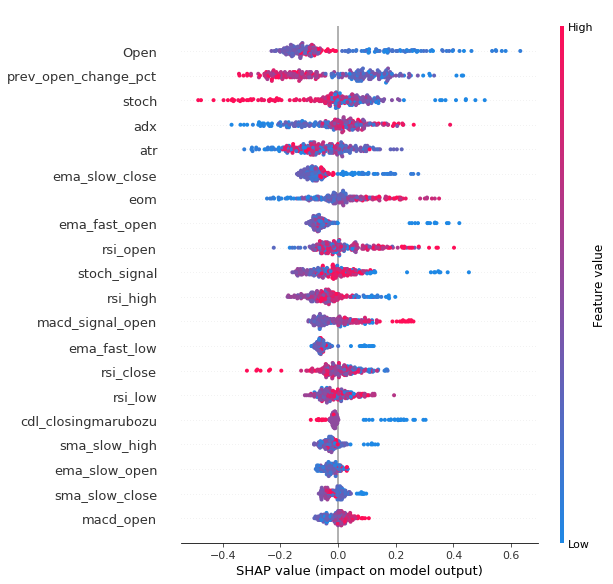

In [312]:
xgb_lprofit_explainer=shap.TreeExplainer(xgb_lprofit)
xgb_lprofit_shapvalues=xgb_lprofit_explainer.shap_values(fcpo_lprofit_testdata)
shap.summary_plot(xgb_lprofit_shapvalues,fcpo_lprofit_testdata)

### Precision and Recall (Long Profit)

In [287]:
print("RF precision : {pscore}, recall: {rscore} auc:{auc_score}".format(pscore=round(precision_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels),2),
                                                     rscore=round(recall_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels),2),
                                                     auc_score=round(roc_auc_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels),2)))

RF precision : 0.52, recall: 0.18 auc:0.54


In [288]:
print("GBM precision : {pscore}, recall: {rscore} auc:{auc_score}".format(
                                        pscore=round(precision_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels),2),
                                        rscore=round(recall_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels),2),
                                        auc_score=round(roc_auc_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels),2)))

GBM precision : 0.53, recall: 0.19 auc:0.55


In [289]:
print("XGB precision : {pscore}, recall: {rscore} auc: {auc_score}".format(pscore=round(precision_score(fcpo_lprofit_testlabels,xgb_lprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_lprofit_testlabels,xgb_lprofit_test_predlabels),2),
                                                     auc_score=round(roc_auc_score(fcpo_lprofit_testlabels,xgb_lprofit_test_predlabels),2)))

XGB precision : 0.55, recall: 0.18 auc: 0.55


### Feature Importance for Short Profit Model

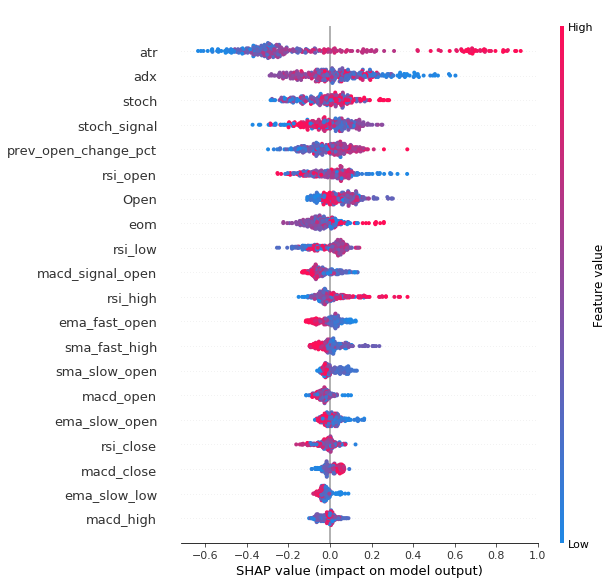

In [44]:
xgb_sprofit_explainer=shap.TreeExplainer(xgb_sprofit)
xgb_sprofit_shapvalues=xgb_sprofit_explainer.shap_values(fcpo_sprofit_testdata)
shap.summary_plot(xgb_sprofit_shapvalues,fcpo_sprofit_testdata)

### Precision and Recall (Short Profit)

In [290]:
print("RF precision : {pscore}, recall: {rscore} auc:{auc_score}".format(
                                                    pscore=round(precision_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels),2),
                                                    rscore=round(recall_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels),2),
                                                    auc_score=round(roc_auc_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels),2)))

RF precision : 0.37, recall: 0.13 auc:0.52


In [291]:
print("GBM precision : {pscore}, recall: {rscore}  auc:{auc_score}".format(
                                                    pscore=round(precision_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels),2),
                                                    rscore=round(recall_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels),2),
                                                    auc_score=round(roc_auc_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels),2)))

GBM precision : 0.33, recall: 0.36  auc:0.52


In [292]:
print("XGB precision : {pscore}, recall: {rscore} auc:{auc_score}".format(pscore=round(precision_score(fcpo_sprofit_testlabels,xgb_sprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_sprofit_testlabels,xgb_sprofit_test_predlabels),2),
                                                     auc_score=round(roc_auc_score(fcpo_sprofit_testlabels,xgb_sprofit_test_predlabels),2)))

XGB precision : 0.36, recall: 0.21 auc:0.52


## Financial Metrics

The final objective of this study is to improve the ROI, hence we are focused on creating a score-card to measure the investement metrics to select the final model,

- Total Returns
- Maximum Drawdown
- Number of Wins
- Number of Losses

**Calculation of Returns**

* When the sprofit_indicator is true, then return is (open_price - next_low_price) - (commission_price),
* Else when the sprofit_indicator is false, the model waits until the end of the day before selling it hence the return is (open_price - next_close_price) - (commission_price)


In [48]:
def calculate_long_returns(x,profit_field,pred_field,commission_price,num_units,profit_thr=0.03,loss_thr=0.01):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
        if x[profit_field]==1:
            return_myr=((x['Open']*(1+profit_thr)-x['Open'])*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x[profit_field]==0:
            max_loss_val=min(x['Low']-x['Open'],x['next_1low']-x['Open'])
            thr_loss_val=(x['Open']*(1-loss_thr))-x['Open']
            if max_loss_val < thr_loss_val:
                return_myr=thr_loss_val*num_units-commission_price
            else:
                return_myr= (x['next_1close']-x['Open'])*num_units-commission_price
    return return_myr

def calculate_short_returns(x,profit_field,pred_field,commission_price,num_units,profit_thr=0.03,loss_thr=0.01):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        if x[profit_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
            return_myr=((x['Open']-x['Open']*(1-profit_thr))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x[profit_field]==0:
            max_loss_val=min(x['Open']-x['High'],x['Open']-x['next_1high'])
            thr_loss_val=x['Open']-(x['Open']*(1+loss_thr))
            if max_loss_val < thr_loss_val:
                return_myr=thr_loss_val*num_units-commission_price
            else:
                return_myr=(x['Open']-x['next_1close'])*num_units-commission_price
    return return_myr

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    mdd_peak=0
    mdd_x=0
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
            mdd_peak=peak
            mdd_x=x
    return mdd_peak,mdd_x,mdd

In [320]:
fcpo_eval_df=fcpo_data_daily[['Open','High','Low','next_1low','next_1high','next_1close',
                             'lprofit_ind_1pct','sprofit_ind_1pct','lprofit_ind_2pct','sprofit_ind_2pct']].merge(
    pd.DataFrame(rf_lprofit_test_predlabels,columns=['rf_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_lprofit_test_predlabels,columns=['gbm_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(xgb_lprofit_test_predlabels,columns=['xgb_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_sprofit_test_predlabels,columns=['gbm_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(rf_sprofit_test_predlabels,columns=['rf_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(xgb_sprofit_test_predlabels,columns=['xgb_sprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True)

fcpo_eval_df['lprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_long_returns(x,'lprofit_ind_2pct','rf_lprofit_prediction',60,25,0.02,0.02),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['lprofit_returns'].cumsum())

fcpo_eval_df['sprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_short_returns(x,'sprofit_ind_2pct','rf_sprofit_prediction',60,25,0.02,0.02),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_sprofit_returns=fcpo_eval_df['sprofit_returns'].cumsum())

fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['cummulative_lprofit_returns']+0,
            cummulative_sprofit_returns=fcpo_eval_df['cummulative_sprofit_returns']+0)

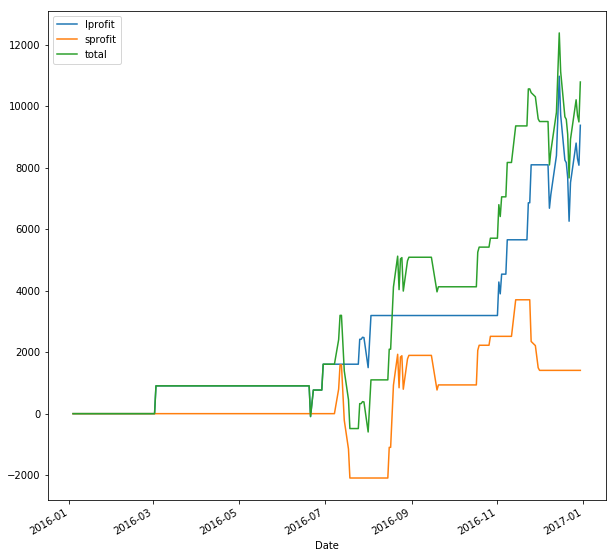

In [321]:
plt.figure(figsize=(10,10))
fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'].plot()
fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns'].plot()
(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns']+
     fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns']).plot()
plt.legend(['lprofit','sprofit','total'])

In [315]:
lprofit_mdd_values=max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'])

sprofit_mdd_values=max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns'])

total_mdd_values=max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns']+
                     fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in double_scalars



In [317]:
print("Long Profit Model MDD:{mdd_value}, from {high_value} to {low_value}".format(mdd_value=round(lprofit_mdd_values[2],2)*100,
                                                                                  high_value=round(lprofit_mdd_values[0]),
                                                                                  low_value=round(lprofit_mdd_values[1])))

Long Profit Model MDD:97.0, from 39 to 1


In [318]:
print("Short Profit Model MDD:{mdd_value}, from {high_value} to {low_value}".format(mdd_value=round(sprofit_mdd_values[2],2)*100,
                                                                                  high_value=round(sprofit_mdd_values[0]),
                                                                                  low_value=round(sprofit_mdd_values[1])))

Short Profit Model MDD:200.99999999999997, from 68 to -69


In [319]:
print("Tota MDD:{mdd_value}, from {high_value} to {low_value}".format(mdd_value=round(total_mdd_values[2],2)*100,
                                                                                  high_value=round(total_mdd_values[0]),
                                                                                  low_value=round(total_mdd_values[1])))

Tota MDD:97.0, from 39 to 1


### Building the Trading signal

In [304]:
def derive_trading_signal(x):
    signal='None'
    if (x['rf_lprofit_prediction']==1 ) & (x['rf_sprofit_prediction']==0):
        signal='Long'
    elif(x['rf_lprofit_prediction']==0) & (x['rf_sprofit_prediction']==1):
        signal='Short'
    else:
        signal='None'
    return signal

In [309]:
trading_signal_df=fcpo_eval_df[['rf_lprofit_prediction','rf_sprofit_prediction']].apply(
    lambda x: derive_trading_signal(x),axis=1)

In [311]:
trading_signal_df.value_counts()

None     190
Long      30
Short     26
dtype: int64

In [228]:
trading_signal_df.to_csv('trading_signal_2016.csv')